# Capstone Project - The Battle of Neighborhoods to get optimal Real-Estate properties

## Business Problem section

### Background

New York City’s housing market has largely recovered from the financial crisis of 2008, but that doesn’t necessarily mean that buying a home here is, in the long run, a good investment. That’s the conclusion from a new report by StreetEasy, which looks at how home values in the city have changed in the 10 years since the Great Recession.
Additionally, home values have overall gone up since the post-crisis low of November 2011. StreetEasy found that those have risen by a whopping 30 percent in the past seven years, at an average of nearly four percent per year.

### Business Problem

The problem scenario is to suggest the homebuyers clientele to purchase a suitable real estate in New York using Machine Learning Algorithms.

As a result, the business problem we are currently posing is:

**How could we provide  suggestions to homebuyers clients to purchase a suitable real estate in New York street in this depreciating economy?**

To solve this business problem, we are going to cluster New York neighborhoods in order to recommend venues and the current average price of real estate where homebuyers can make a real estate investment.Also we will recommend profitable venues  venues i.e. pharmacy, restaurants, hospitals & grocery stores.

## Data Section

The Department of Finance (DOF) maintains records for all property sales in New York City, including sales of family homes in each borough(https://data.cityofnewyork.us/api/views/948r-3ads/rows.csv?accessType=DOWNLOAD). 

This list includes all sales of 1-, 2-, and 3-Family Homes' from January 1st, 2009 to December 31, 2009, whose sale price is equal to or more than $150,000. The Building Class Category for Sales is based on the Building Class at the time of the sale. 

To explore and target recommended locations across different venues according to the presence of amenities and essential facilities, we will access data through FourSquare API interface and arrange them as a dataframe for visualization. By merging data on New York properties and the relative price paid data from the HM Land Registry and data on amenities and essential facilities surrounding such properties from FourSquare API interface, we will be able to recommend profitable real estate investments.

## Methodology

1. Collect Inspection Data
2. Explore and Understand Data
3. Data preparation and preprocessing 
4. Modeling

# Implementation

In [70]:
#Beautifulsoup library helps in web scraping data from webpage
from bs4 import BeautifulSoup
#lxml library is the parser used to parse the content from diffrent HTML Tags
import lxml
# Requests library helps in getting the content of the webpage
import requests as req
# library to handle data in a vectorized manner
import numpy as np
#library for Data Analysis
import pandas as pd
# library to handle JSON files
import json 
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 
# library to handle requests
import requests 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib as plt
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# map rendering library
import folium 
# library to find median of List
from numpy import median
print('Libraries imported.')

Libraries imported.


## 1. Collect Inspection data

In [71]:
# Download the Neighbourhood of NewYork with price dataset
!wget -O ny_neighbourhood.csv  https://data.cityofnewyork.us/api/views/948r-3ads/rows.csv?accessType=DOWNLOAD

--2019-03-17 07:33:16--  https://data.cityofnewyork.us/api/views/948r-3ads/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘ny_neighbourhood.csv’

ny_neighbourhood.cs     [ <=>                  ]  18.18K  --.-KB/s   in 0s     

2019-03-17 07:33:17 (154 MB/s) - ‘ny_neighbourhood.csv’ saved [18612]



## 2. Explore Data

In [72]:
#Reading the dataset value to DataFrame
original_data=pd.read_csv('ny_neighbourhood.csv')
original_data.head()

,NEIGHBORHOOD,TYPE OF HOME,TOTAL NO. OF PROPERTIES,NUMBER OF SALES,LOWEST SALE PRICE,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE
0,AIRPORT LA GUARDIA,01 ONE FAMILY HOMES,84,1,485000.0,485000.0,485000.0,485000.0
1,AIRPORT LA GUARDIA,02 TWO FAMILY HOMES,14,1,480000.0,480000.0,480000.0,480000.0
2,ARVERNE,01 ONE FAMILY HOMES,696,32,161000.0,297194.0,310276.0,390291.0
3,ARVERNE,02 TWO FAMILY HOMES,1528,112,160000.0,505043.0,427868.0,1170987.0
4,ARVERNE,03 THREE FAMILY HOMES,137,6,165000.0,414658.0,506796.0,582320.0


##  3. Preprocessing 

In [73]:
#Label Encoding for Type of Homes
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
original_data['TYPE OF HOME'] = labelencoder.fit_transform(original_data['TYPE OF HOME'])
original_data.head()

,NEIGHBORHOOD,TYPE OF HOME,TOTAL NO. OF PROPERTIES,NUMBER OF SALES,LOWEST SALE PRICE,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE
0,AIRPORT LA GUARDIA,0,84,1,485000.0,485000.0,485000.0,485000.0
1,AIRPORT LA GUARDIA,1,14,1,480000.0,480000.0,480000.0,480000.0
2,ARVERNE,0,696,32,161000.0,297194.0,310276.0,390291.0
3,ARVERNE,1,1528,112,160000.0,505043.0,427868.0,1170987.0
4,ARVERNE,2,137,6,165000.0,414658.0,506796.0,582320.0


The following Label Encoded value can be mapped as follows:

**0  = 01 ONE FAMILY HOMES**  
**1  = 02 TWO FAMILY HOMES**  
**2  = 03 THREE FAMILY HOMES**

In [74]:
count=0
lat=[]
lon=[]
from geopy.geocoders import Nominatim
for i in original_data['NEIGHBORHOOD']:
    address = i+' , New York, USA'

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location==None:
        latitude = 40.7136
        longitude = -73.7965
        #print('{},{},{}'.format(address,latitude,longitude))
        lat.append(latitude)
        lon.append(longitude)
        continue
    latitude = location.latitude
    longitude = location.longitude
    #print('{},{},{}'.format(address,latitude,longitude))
    lat.append(latitude)
    lon.append(longitude)
    
    
#Outlier Reduction and Treatment
lat_med=median(lat)
lon_med=median(lon)
for i in range(0,len(lat)):
    #print(lat[i])
    if lat[i]>41:
        lat[i]=lat_med
        #print(lat[i])
for i in range(0,len(lon)):
    #print(lat[i])
    if lon[i]<-74:
        lon[i]=lon_med
        #print(lat[i])

#print(lat)
original_data['LONGITUDE']=lon
original_data['LATITUDE']=lat



In [75]:
#Getting the Data 
original_data.head()


,NEIGHBORHOOD,TYPE OF HOME,TOTAL NO. OF PROPERTIES,NUMBER OF SALES,LOWEST SALE PRICE,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,LONGITUDE,LATITUDE
0,AIRPORT LA GUARDIA,0,84,1,485000.0,485000.0,485000.0,485000.0,-73.873364,40.775714
1,AIRPORT LA GUARDIA,1,14,1,480000.0,480000.0,480000.0,480000.0,-73.873364,40.775714
2,ARVERNE,0,696,32,161000.0,297194.0,310276.0,390291.0,-73.789546,40.593417
3,ARVERNE,1,1528,112,160000.0,505043.0,427868.0,1170987.0,-73.789546,40.593417
4,ARVERNE,2,137,6,165000.0,414658.0,506796.0,582320.0,-73.789546,40.593417


In [76]:
#Getting the Geographical Location both Longitude and Latitude of New York , USA
from geopy.geocoders import Nominatim
address = 'NEW YORK'
geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


## Plotting the Neighborhoods of NewYork present in Dataset

In [77]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, price, street in zip(original_data['LATITUDE'], original_data['LONGITUDE'], original_data['AVERAGE SALE PRICE'], original_data['NEIGHBORHOOD']):
    label = '{}, {}'.format(street, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [78]:
CLIENT_ID = 'TZ2P2CCEDAWFAQXREEPK30XUHXJD20G4JMEKDH0PZ4KESADF' # Foursquare ID
CLIENT_SECRET = '4FEVNVQT5FQ2XKR2X1YPSDM4NE3B4SC2BDDBSJB43VWDONCB' # Foursquare Secret
VERSION = '20190226' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TZ2P2CCEDAWFAQXREEPK30XUHXJD20G4JMEKDH0PZ4KESADF
CLIENT_SECRET:4FEVNVQT5FQ2XKR2X1YPSDM4NE3B4SC2BDDBSJB43VWDONCB


In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Street', 
                  'Street Latitude', 
                  'Street Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Getting Near By Venues of New York

In [80]:
newyork_venues = getNearbyVenues(names=original_data['NEIGHBORHOOD'],
                                   latitudes=original_data['LATITUDE'],
                                   longitudes=original_data['LONGITUDE']
                                  )
newyork_venues

AIRPORT LA GUARDIA       
AIRPORT LA GUARDIA       
ARVERNE                  
ARVERNE                  
ARVERNE                  
ASTORIA                  
ASTORIA                  
ASTORIA                  
BAYSIDE                  
BAYSIDE                  
BAYSIDE                  
BEECHHURST               
BEECHHURST               
BELLE HARBOR             
BELLE HARBOR             
BELLEROSE                
BELLEROSE                
BRIARWOOD                
BRIARWOOD                
BRIARWOOD                
BROAD CHANNEL            
BROAD CHANNEL            
CAMBRIA HEIGHTS          
CAMBRIA HEIGHTS          
COLLEGE POINT            
COLLEGE POINT            
COLLEGE POINT            
CORONA                   
CORONA                   
CORONA                   
DOUGLASTON               
DOUGLASTON               
EAST ELMHURST            
EAST ELMHURST            
EAST ELMHURST            
ELMHURST                 
ELMHURST                 
ELMHURST                 
FAR ROCKAWAY

,Street,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AIRPORT LA GUARDIA,40.775714,-73.873364,The Centurion Lounge LaGuardia,40.774511,-73.871962,Airport Lounge
1,AIRPORT LA GUARDIA,40.775714,-73.873364,Shoe Shine AA,40.775239,-73.874322,Shoe Repair
2,AIRPORT LA GUARDIA,40.775714,-73.873364,Five Guys,40.774219,-73.873859,Burger Joint
3,AIRPORT LA GUARDIA,40.775714,-73.873364,7-Eleven,40.763868,-73.881667,Convenience Store
4,AIRPORT LA GUARDIA,40.775714,-73.873364,Delta Sky Club,40.769101,-73.862337,Airport Lounge
5,AIRPORT LA GUARDIA,40.775714,-73.873364,Shake Shack,40.773936,-73.869490,Burger Joint
6,AIRPORT LA GUARDIA,40.775714,-73.873364,"Airways Pizza, Gyro & Restaurant",40.763781,-73.878553,Pizza Place
7,AIRPORT LA GUARDIA,40.775714,-73.873364,Starbucks,40.775290,-73.874180,Coffee Shop
8,AIRPORT LA GUARDIA,40.775714,-73.873364,La Guardia Café,40.768226,-73.873524,Café
9,AIRPORT LA GUARDIA,40.775714,-73.873364,Delta Sky Club,40.771701,-73.865391,Airport Lounge


In [81]:
# Grouping the venues according to Street
newyork_venues.groupby('Street').count()


,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Street,,,,,,
AIRPORT LA GUARDIA,200,200,200,200,200,200
ARVERNE,195,195,195,195,195,195
ASTORIA,300,300,300,300,300,300
BAYSIDE,300,300,300,300,300,300
BEECHHURST,156,156,156,156,156,156
BELLE HARBOR,130,130,130,130,130,130
BELLEROSE,200,200,200,200,200,200
BRIARWOOD,300,300,300,300,300,300
BROAD CHANNEL,120,120,120,120,120,120


Text(0, 0.5, 'Count')

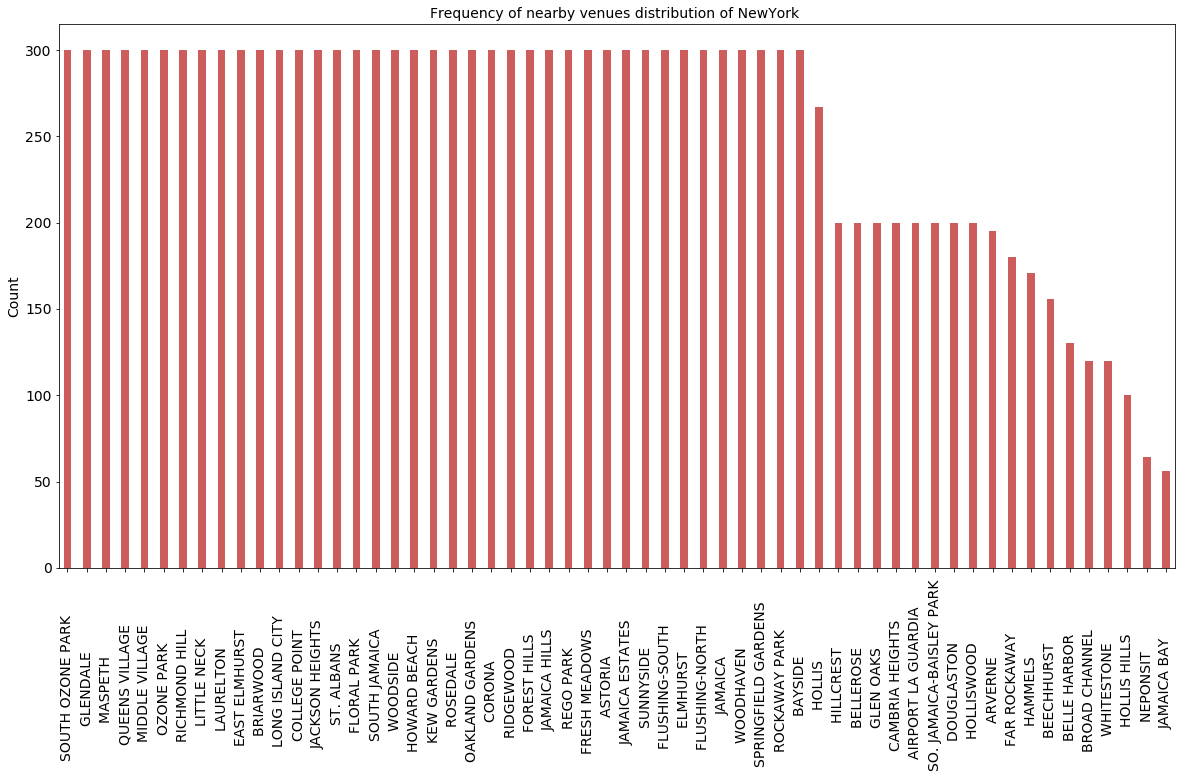

In [82]:
ax = newyork_venues['Street'].value_counts().plot(kind='bar', figsize=(20, 10),color=['#CD5C5C'],fontsize=14, width=0.4)

ax.set_title('Frequency of nearby venues distribution of NewYork ',fontsize=14)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.set_ylabel('Count',fontsize=14)

In [84]:
# get the List of Unique Categories
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 293 uniques categories.


In [83]:
newyork_venues.shape

(14859, 7)

In [85]:
# one hot encoding
venues_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add street column back to dataframe
venues_onehot['Street'] = newyork_venues['Street'] 

# move street column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])

#fixed_columns
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Street,Accessories Store,Afghan Restaurant,Airport Lounge,Airport Service,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,AIRPORT LA GUARDIA,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AIRPORT LA GUARDIA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AIRPORT LA GUARDIA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AIRPORT LA GUARDIA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AIRPORT LA GUARDIA,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
newyork_grouped = venues_onehot.groupby('Street').mean().reset_index()
newyork_grouped.head()

,Street,Accessories Store,Afghan Restaurant,Airport Lounge,Airport Service,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,AIRPORT LA GUARDIA,0.01,0.0,0.04,0.02,0.01,0.00,0.01,0.0,0.0,...,0.01,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,ARVERNE,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.00,0.000000,0.000000,0.0,0.030769,0.0,0.0,0.0,0.000000,0.0
2,ASTORIA,0.00,0.0,0.00,0.00,0.01,0.01,0.00,0.0,0.0,...,0.00,0.000000,0.000000,0.0,0.020000,0.0,0.0,0.0,0.020000,0.0
3,BAYSIDE,0.00,0.0,0.00,0.00,0.02,0.00,0.00,0.0,0.0,...,0.00,0.010000,0.000000,0.0,0.010000,0.0,0.0,0.0,0.010000,0.0
4,BEECHHURST,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.00,0.012821,0.012821,0.0,0.000000,0.0,0.0,0.0,0.012821,0.0


In [87]:
newyork_grouped.shape

(58, 294)

## Top Five Venues

In [88]:
num_top_venues = 5

for hood in newyork_grouped['Street']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Street'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AIRPORT LA GUARDIA       ----
                       venue  freq
0                Pizza Place  0.07
1                 Donut Shop  0.05
2                     Bakery  0.05
3  Latin American Restaurant  0.04
4        Rental Car Location  0.04


----ARVERNE                  ----
         venue  freq
0        Beach  0.14
1   Donut Shop  0.06
2    Surf Spot  0.06
3  Pizza Place  0.06
4  Supermarket  0.05


----ASTORIA                  ----
                venue  freq
0    Greek Restaurant  0.09
1  Italian Restaurant  0.05
2                 Bar  0.05
3                Park  0.04
4          Bagel Shop  0.04


----BAYSIDE                  ----
                venue  freq
0              Bakery  0.05
1   Korean Restaurant  0.05
2    Greek Restaurant  0.04
3  Italian Restaurant  0.04
4      Cosmetics Shop  0.04


----BEECHHURST               ----
                venue  freq
0                Park  0.10
1         Pizza Place  0.09
2  Italian Restaurant  0.08
3       Deli / Bodega  0.06
4  Chinese

In [89]:
# Define a function to return the most common venues/facilities nearby real estate investments#

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [90]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [91]:
# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Street'] = newyork_grouped['Street']

for ind in np.arange(newyork_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

In [93]:
venues_sorted.head()


,Street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AIRPORT LA GUARDIA,Pizza Place,Donut Shop,Bakery,Rental Car Location,Ice Cream Shop,Latin American Restaurant,Airport Lounge,Burger Joint,Pharmacy,Coffee Shop
1,ARVERNE,Beach,Pizza Place,Donut Shop,Surf Spot,Supermarket,Board Shop,Bus Stop,Grocery Store,Bar,Metro Station
2,ASTORIA,Greek Restaurant,Italian Restaurant,Bar,Bagel Shop,Park,Sushi Restaurant,Bakery,Sandwich Place,Food Truck,Coffee Shop
3,BAYSIDE,Bakery,Korean Restaurant,Cosmetics Shop,Italian Restaurant,Greek Restaurant,Gym / Fitness Center,Pizza Place,Bagel Shop,Bar,Ice Cream Shop
4,BEECHHURST,Park,Pizza Place,Italian Restaurant,Deli / Bodega,Ice Cream Shop,Chinese Restaurant,Bagel Shop,History Museum,Donut Shop,Beach


## 4. Modelling

## Determining the Optimal K Value for KMeans algorithm

In [94]:
newyork_grouped_clustering = newyork_grouped.drop('Street', 1)
Sum_of_squared_distances = []
K = range(1,15)
for kclusters in K:
    kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(newyork_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

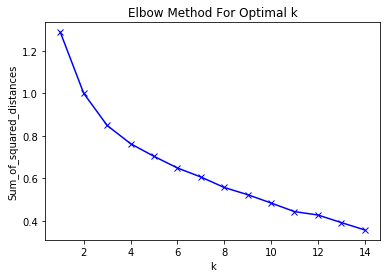

In [95]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### From above graph the Elbow point is in **k=4** which is the optimal value of K-Means clustering

In [96]:
# set number of clusters
kclusters = 4

newyork_grouped_clustering = newyork_grouped.drop('Street', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 1, 1, 3, 2, 3, 1, 3, 0], dtype=int32)

In [50]:
#newyork_merged.drop('Cluster Labels',1)
#venues_sorted.drop('Cluster Labels',1,inplace=True)


In [97]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = original_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(venues_sorted.set_index('Street'), on='NEIGHBORHOOD')

newyork_merged.head() # check the last columns!


,NEIGHBORHOOD,TYPE OF HOME,TOTAL NO. OF PROPERTIES,NUMBER OF SALES,LOWEST SALE PRICE,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,LONGITUDE,LATITUDE,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AIRPORT LA GUARDIA,0,84,1,485000.0,485000.0,485000.0,485000.0,-73.873364,40.775714,...,Pizza Place,Donut Shop,Bakery,Rental Car Location,Ice Cream Shop,Latin American Restaurant,Airport Lounge,Burger Joint,Pharmacy,Coffee Shop
1,AIRPORT LA GUARDIA,1,14,1,480000.0,480000.0,480000.0,480000.0,-73.873364,40.775714,...,Pizza Place,Donut Shop,Bakery,Rental Car Location,Ice Cream Shop,Latin American Restaurant,Airport Lounge,Burger Joint,Pharmacy,Coffee Shop
2,ARVERNE,0,696,32,161000.0,297194.0,310276.0,390291.0,-73.789546,40.593417,...,Beach,Pizza Place,Donut Shop,Surf Spot,Supermarket,Board Shop,Bus Stop,Grocery Store,Bar,Metro Station
3,ARVERNE,1,1528,112,160000.0,505043.0,427868.0,1170987.0,-73.789546,40.593417,...,Beach,Pizza Place,Donut Shop,Surf Spot,Supermarket,Board Shop,Bus Stop,Grocery Store,Bar,Metro Station
4,ARVERNE,2,137,6,165000.0,414658.0,506796.0,582320.0,-73.789546,40.593417,...,Beach,Pizza Place,Donut Shop,Surf Spot,Supermarket,Board Shop,Bus Stop,Grocery Store,Bar,Metro Station


In [57]:
#newyork_merged.to_csv('A_data.csv')

In [98]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['LATITUDE'], newyork_merged['LONGITUDE'], newyork_merged['NEIGHBORHOOD'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Data in Cluster 1 after KMeans

In [99]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,TYPE OF HOME,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,LONGITUDE,LATITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,0,339606.0,356200.0,479824.0,-73.738465,40.694547,0,Caribbean Restaurant,Pharmacy,Pizza Place,Donut Shop,Discount Store,Convenience Store,Supermarket,Sandwich Place,Ice Cream Shop,Deli / Bodega
23,1,359528.0,349750.0,624000.0,-73.738465,40.694547,0,Caribbean Restaurant,Pharmacy,Pizza Place,Donut Shop,Discount Store,Convenience Store,Supermarket,Sandwich Place,Ice Cream Shop,Deli / Bodega
78,0,343356.0,320000.0,548642.0,-73.805677,40.691485,0,Caribbean Restaurant,Indian Restaurant,Latin American Restaurant,Park,Coffee Shop,Pharmacy,Diner,Southern / Soul Food Restaurant,BBQ Joint,Lounge
79,1,455949.0,450000.0,770000.0,-73.805677,40.691485,0,Caribbean Restaurant,Indian Restaurant,Latin American Restaurant,Park,Coffee Shop,Pharmacy,Diner,Southern / Soul Food Restaurant,BBQ Joint,Lounge
80,2,576935.0,630000.0,811952.0,-73.805677,40.691485,0,Caribbean Restaurant,Indian Restaurant,Latin American Restaurant,Park,Coffee Shop,Pharmacy,Diner,Southern / Soul Food Restaurant,BBQ Joint,Lounge
92,0,328841.0,339000.0,570000.0,-73.751521,40.666770,0,Caribbean Restaurant,Pizza Place,Donut Shop,Sandwich Place,Fast Food Restaurant,Discount Store,Convenience Store,Shipping Store,Park,Pharmacy
93,1,389841.0,373000.0,620000.0,-73.751521,40.666770,0,Caribbean Restaurant,Pizza Place,Donut Shop,Sandwich Place,Fast Food Restaurant,Discount Store,Convenience Store,Shipping Store,Park,Pharmacy
94,2,370000.0,370000.0,370000.0,-73.751521,40.666770,0,Caribbean Restaurant,Pizza Place,Donut Shop,Sandwich Place,Fast Food Restaurant,Discount Store,Convenience Store,Shipping Store,Park,Pharmacy
129,0,349033.0,350000.0,645000.0,-73.735410,40.662048,0,Caribbean Restaurant,Clothing Store,Park,Convenience Store,Donut Shop,Sandwich Place,Pizza Place,Furniture / Home Store,Cosmetics Shop,Department Store
130,1,473370.0,478723.0,3500000.0,-73.735410,40.662048,0,Caribbean Restaurant,Clothing Store,Park,Convenience Store,Donut Shop,Sandwich Place,Pizza Place,Furniture / Home Store,Cosmetics Shop,Department Store


## Data in Cluster 2 after KMeans


In [100]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,TYPE OF HOME,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,LONGITUDE,LATITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,0,552234.0,556000.0,1207099.0,-73.930267,40.772014,1,Greek Restaurant,Italian Restaurant,Bar,Bagel Shop,Park,Sushi Restaurant,Bakery,Sandwich Place,Food Truck,Coffee Shop
6,1,689831.0,700000.0,1600000.0,-73.930267,40.772014,1,Greek Restaurant,Italian Restaurant,Bar,Bagel Shop,Park,Sushi Restaurant,Bakery,Sandwich Place,Food Truck,Coffee Shop
7,2,653181.0,715000.0,1070000.0,-73.930267,40.772014,1,Greek Restaurant,Italian Restaurant,Bar,Bagel Shop,Park,Sushi Restaurant,Bakery,Sandwich Place,Food Truck,Coffee Shop
8,0,606888.0,600000.0,2225000.0,-73.777077,40.768435,1,Bakery,Korean Restaurant,Cosmetics Shop,Italian Restaurant,Greek Restaurant,Gym / Fitness Center,Pizza Place,Bagel Shop,Bar,Ice Cream Shop
9,1,751116.0,777500.0,1110000.0,-73.777077,40.768435,1,Bakery,Korean Restaurant,Cosmetics Shop,Italian Restaurant,Greek Restaurant,Gym / Fitness Center,Pizza Place,Bagel Shop,Bar,Ice Cream Shop
10,2,814500.0,872500.0,1075000.0,-73.777077,40.768435,1,Bakery,Korean Restaurant,Cosmetics Shop,Italian Restaurant,Greek Restaurant,Gym / Fitness Center,Pizza Place,Bagel Shop,Bar,Ice Cream Shop
17,0,428607.0,430000.0,650000.0,-73.818783,40.726769,1,Pizza Place,Bakery,Park,Sushi Restaurant,Chinese Restaurant,Bar,Bagel Shop,Italian Restaurant,Vegetarian / Vegan Restaurant,Juice Bar
18,1,500948.0,492000.0,615500.0,-73.818783,40.726769,1,Pizza Place,Bakery,Park,Sushi Restaurant,Chinese Restaurant,Bar,Bagel Shop,Italian Restaurant,Vegetarian / Vegan Restaurant,Juice Bar
19,2,569985.0,730000.0,760000.0,-73.818783,40.726769,1,Pizza Place,Bakery,Park,Sushi Restaurant,Chinese Restaurant,Bar,Bagel Shop,Italian Restaurant,Vegetarian / Vegan Restaurant,Juice Bar
27,0,400471.0,350000.0,790000.0,-73.860146,40.746959,1,Tennis Stadium,South American Restaurant,Latin American Restaurant,Pizza Place,Bakery,Italian Restaurant,Thai Restaurant,Lingerie Store,Empanada Restaurant,Burger Joint


## Data in Cluster 3 after KMeans


In [101]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,TYPE OF HOME,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,LONGITUDE,LATITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,0,297194.0,310276.0,390291.0,-73.789546,40.593417,2,Beach,Pizza Place,Donut Shop,Surf Spot,Supermarket,Board Shop,Bus Stop,Grocery Store,Bar,Metro Station
3,1,505043.0,427868.0,1170987.0,-73.789546,40.593417,2,Beach,Pizza Place,Donut Shop,Surf Spot,Supermarket,Board Shop,Bus Stop,Grocery Store,Bar,Metro Station
4,2,414658.0,506796.0,582320.0,-73.789546,40.593417,2,Beach,Pizza Place,Donut Shop,Surf Spot,Supermarket,Board Shop,Bus Stop,Grocery Store,Bar,Metro Station
13,0,720756.0,700000.0,1225000.0,-73.848577,40.577552,2,Beach,Deli / Bodega,Pizza Place,Ice Cream Shop,Bagel Shop,Pharmacy,Bank,Park,Supermarket,Bus Stop
14,1,737708.0,700000.0,1275000.0,-73.848577,40.577552,2,Beach,Deli / Bodega,Pizza Place,Ice Cream Shop,Bagel Shop,Pharmacy,Bank,Park,Supermarket,Bus Stop
38,0,462934.0,433111.0,900000.0,-73.755133,40.605382,2,Beach,Pizza Place,Supermarket,Sandwich Place,Donut Shop,Discount Store,Fast Food Restaurant,Grocery Store,Golf Course,Bank
39,1,346504.0,289495.0,750000.0,-73.755133,40.605382,2,Beach,Pizza Place,Supermarket,Sandwich Place,Donut Shop,Discount Store,Fast Food Restaurant,Grocery Store,Golf Course,Bank
40,2,429958.0,481000.0,647200.0,-73.755133,40.605382,2,Beach,Pizza Place,Supermarket,Sandwich Place,Donut Shop,Discount Store,Fast Food Restaurant,Grocery Store,Golf Course,Bank
61,0,273274.0,315000.0,325000.0,-73.811151,40.588822,2,Beach,Surf Spot,Bagel Shop,Beach Bar,Wine Bar,Hotel,Frozen Yogurt Shop,Board Shop,Taco Place,Steakhouse
62,1,373778.0,406660.0,506908.0,-73.811151,40.588822,2,Beach,Surf Spot,Bagel Shop,Beach Bar,Wine Bar,Hotel,Frozen Yogurt Shop,Board Shop,Taco Place,Steakhouse


## Data in Cluster 4 after KMeans


In [102]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,TYPE OF HOME,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,LONGITUDE,LATITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,485000.0,485000.0,485000.0,-73.873364,40.775714,3,Pizza Place,Donut Shop,Bakery,Rental Car Location,Ice Cream Shop,Latin American Restaurant,Airport Lounge,Burger Joint,Pharmacy,Coffee Shop
1,1,480000.0,480000.0,480000.0,-73.873364,40.775714,3,Pizza Place,Donut Shop,Bakery,Rental Car Location,Ice Cream Shop,Latin American Restaurant,Airport Lounge,Burger Joint,Pharmacy,Coffee Shop
11,0,679765.0,650000.0,1125000.0,-73.804578,40.791490,3,Park,Pizza Place,Italian Restaurant,Deli / Bodega,Ice Cream Shop,Chinese Restaurant,Bagel Shop,History Museum,Donut Shop,Beach
12,1,1235000.0,1235000.0,1560000.0,-73.804578,40.791490,3,Park,Pizza Place,Italian Restaurant,Deli / Bodega,Ice Cream Shop,Chinese Restaurant,Bagel Shop,History Museum,Donut Shop,Beach
15,0,445081.0,440000.0,780000.0,-73.715131,40.724269,3,Pizza Place,Indian Restaurant,Mobile Phone Shop,Bar,Deli / Bodega,Italian Restaurant,Coffee Shop,Donut Shop,Pharmacy,Sandwich Place
16,1,525935.0,517000.0,1450000.0,-73.715131,40.724269,3,Pizza Place,Indian Restaurant,Mobile Phone Shop,Bar,Deli / Bodega,Italian Restaurant,Coffee Shop,Donut Shop,Pharmacy,Sandwich Place
20,0,323210.0,330000.0,529881.0,-73.819019,40.606401,3,Beach,Pizza Place,Chinese Restaurant,Beach Bar,Bagel Shop,Bar,Supermarket,Surf Spot,Brazilian Restaurant,Ice Cream Shop
21,1,450000.0,450000.0,450000.0,-73.819019,40.606401,3,Beach,Pizza Place,Chinese Restaurant,Beach Bar,Bagel Shop,Bar,Supermarket,Surf Spot,Brazilian Restaurant,Ice Cream Shop
24,0,452241.0,435000.0,977520.0,-73.845968,40.787601,3,Pizza Place,Donut Shop,Park,Ice Cream Shop,Fast Food Restaurant,Coffee Shop,Supermarket,Sandwich Place,Bakery,Gym
25,1,629599.0,599468.0,1160805.0,-73.845968,40.787601,3,Pizza Place,Donut Shop,Park,Ice Cream Shop,Fast Food Restaurant,Coffee Shop,Supermarket,Sandwich Place,Bakery,Gym


In [103]:
mean_data=newyork_merged.groupby('Cluster Labels')['AVERAGE SALE PRICE'].mean()
mean_data=pd.DataFrame(mean_data)
mean_data

,AVERAGE SALE PRICE
Cluster Labels,
0,403649.400000
1,610196.027397
2,474991.333333
3,511496.795918


Text(0, 0.5, 'AVERAGE SALE PRICE')

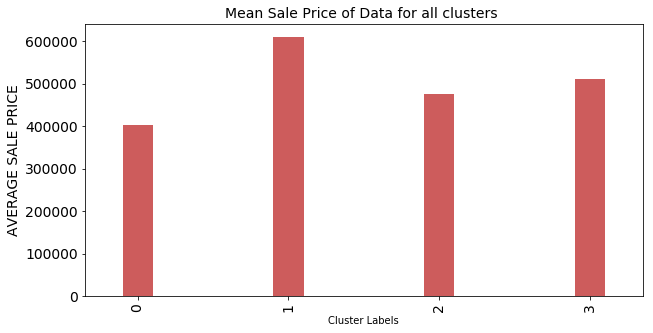

In [104]:
ax = mean_data['AVERAGE SALE PRICE'].plot(kind='bar', figsize=(10, 5),color=['#CD5C5C'],fontsize=14, width=0.2)

ax.set_title('Mean Sale Price of Data for all clusters ',fontsize=14)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.set_ylabel('AVERAGE SALE PRICE',fontsize=14)

In [105]:

median_data=newyork_merged.groupby('Cluster Labels')['MEDIAN SALE PRICE'].mean()
median_data=pd.DataFrame(median_data)
median_data

,MEDIAN SALE PRICE
Cluster Labels,
0,406267.950000
1,607131.506849
2,458104.600000
3,506990.959184


Text(0, 0.5, 'MEDIAN SALE PRICE')

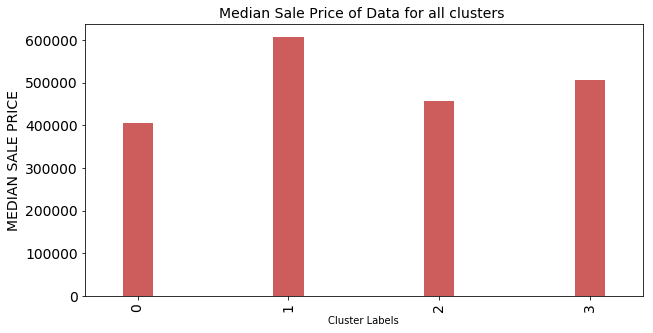

In [106]:
ax = median_data['MEDIAN SALE PRICE'].plot(kind='bar', figsize=(10, 5),color=['#CD5C5C'],fontsize=14, width=0.2)

ax.set_title('Median Sale Price of Data for all clusters ',fontsize=14)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.set_ylabel('MEDIAN SALE PRICE',fontsize=14)

## Result

First of all, even though the London Housing Market may be in a rut, it is still an "ever-green" for business affairs.

Key Observations under the Results:

First, we may examine them according to neighborhoods of New York Areas.


Cluster O:

1. The average and Median price of Cluster one Neighborhoods are 403649.400000 and 406267.950000 respectively.
2. The cluster contains following places -
    CAMBRIA HEIGHTS          
    JAMAICA                  
    LAURELTON                
    ROSEDALE                 
    SOUTH JAMAICA            
    SPRINGFIELD GARDENS      
    ST. ALBANS               
3. The most common venues nearby are Food Corner , Restaurants, Bank , Park. The no of Sales is less with respect to available properties.
4. The properties are best to buy as it has very reasonable average and median rates and in addition to that it has elementary stuffs for daily needs .
5. The place is best for food and restaurants but frequency of other amenities like hospital, schools is less.

Cluster 1:

1. The average and Median price of Cluster one Neighborhoods are 610196.027397 and 607131.506849 respectively.
2. The cluster contains following places -
    ASTORIA                  
    BAYSIDE                  
    BRIARWOOD                
    CORONA                   
    DOUGLASTON               
    EAST ELMHURST            
    ELMHURST                 
    FLUSHING-NORTH           
    FLUSHING-SOUTH           
    FOREST HILLS             
    FRESH MEADOWS            
    GLENDALE                 
    HILLCREST                
    JACKSON HEIGHTS          
    KEW GARDENS              
    LITTLE NECK              
    LONG ISLAND CITY         
    MASPETH                  
    MIDDLE VILLAGE           
    OAKLAND GARDENS          
    REGO PARK                
    RICHMOND HILL            
    RIDGEWOOD                
    SUNNYSIDE                
    WOODSIDE                 

3. The average and median price is more compare to all other clusters .The most common venues nearby are  Supermarkets , Restaurants, Bar , Park and Bagel Shop.

Cluster 2:

1. The average and Median price of Cluster one Neighborhoods are 474991.333333 and 458104.6 respectively.
2. The cluster contains following places-
    ARVERNE                  
    BELLE HARBOR             
    FAR ROCKAWAY             
    HAMMELS                  
    NEPONSIT                 
    ROCKAWAY PARK            
3. The most common venues nearby are Beach, Pizza place,Bank,Bus stop and all kinds of Food Corners.
4. This should be second most preferred properties after Cluster 0 properties due to its average and median rates.

Cluster 3:

1. The average and Median price of Cluster one Neighborhoods are 511496.795918 and 458104.600000 respectively.
2. The cluster contains following places-
    AIRPORT LA GUARDIA       
    BEECHHURST               
    BELLEROSE                
    BROAD CHANNEL            
    COLLEGE POINT            
    FLORAL PARK              
    GLEN OAKS                
    HOLLIS                   
    HOLLIS HILLS             
    HOLLISWOOD               
    HOWARD BEACH             
    JAMAICA BAY              
    JAMAICA ESTATES          
    JAMAICA HILLS            
    OZONE PARK               
    QUEENS VILLAGE           
    SO. JAMAICA-BAISLEY PARK 
    SOUTH OZONE PARK         
    WHITESTONE               
    WOODHAVEN                
3. The most common venues nearby are Airport Lounge,Burger Joint,Pharmacy,Coffee Shop ,Parks etc.
.
4. The real estate properties are more expensive after cluster 1 properties.

## Conclusion

At Last we state the problem scenario.

The problem scenario is to suggest the home buyers clients to purchase a suitable real estate in New York using Machine Learning Algorithms.

As a result, the business problem we are currently posing is:

How could we provide suggestions to home buyers clients to purchase a suitable real estate in New York street in this depreciating economy?

To solve this business problem, we are going to cluster New York neighborhoods in order to recommend venues and the current average price of real estate where home buyers can make a real estate investment.Also we will recommend profitable venues venues i.e. pharmacy , restaurants, hospitals & grocery stores.

First, we gathered data from The Department of Finance (DOF) maintains records for all property sales in New York City, including sales of family homes in each borough(https://data.cityofnewyork.us/api/views/948r-3ads/rows.csv?accessType=DOWNLOAD).

This list includes all sales of 1-, 2-, and 3-Family Homes' from January 1st, 2009 to December 31, 2009, whose sale price is equal to or more than $150,000. The Building Class Category for Sales is based on the Building Class at the time of the sale.

To explore and target recommended locations across different venues according to the presence of amenities and essential facilities, we will access data through FourSquare API interface and arrange them as a dataframe for visualization. By merging data on New York properties and the relative price paid data from the HM Land Registry and data on amenities and essential facilities surrounding such properties from FourSquare API interface, we will be able to recommend profitable real estate investments.


At last ,  We may analyze our results according to the five clusters we have produced. Even though, all clusters could praise an optimal range of facilities and amenities.

Cluster 3 - It have properties with almost average and median nearly close to each other and also the common venues also matching to each other but properties has more                 expensive than Cluster 1.

Cluster 0 and 2 - The average and median price is less compare to other clusters.

Cluster 1 - The average and median price is more compare to other clusters.